### Metaparameter & dataset description
Load meta structure before using any subsequent code. Its required for most of functions and operations.

In [1]:
#--- path to graph vector data
path = 'data/graph/'

#--- metadata
meta = dict()
meta['atl'] = ['pow','har','dos','aal','mul'] 
meta['mod'] = ['cor','cov','par','pre']
meta['thr'] = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]
meta['N_sub'] = 40  # number of subjects
meta['N_ses'] = 4   # number of sessions per subject
meta['N_gvm'] = 10  # number of graph measures 

### (A) Finding best possible combination of metaparameters
Calculating quality function for single combination of graph vectors (one atlas, one model, one threshold). Information is stored in dictionary q having separate 2D arrays for each model. Each row of this array corresponds to certain atlas, and columns correspond to thresholds. 

In [2]:
from identipy import load_data
from identipy import beta_lin_comb
from identipy import quality_function
import numpy as np

#--- load data
GVDAT, sub_list = load_data(path, meta)

N_thr = len(meta['thr'])
N_atl = len(meta['atl'])
q = {}
for mod in meta['mod']:
    #--- store results in array for each model separately
    q[mod] = np.zeros([N_atl, N_thr])
    for tup in [(atl, thr) for atl in range(N_atl) for thr in range(N_thr)]:
        # print(' Model: {}, Atlas: {}, Threshold: {}'.format(mod, meta['atl'][tup[0]], str(tup[1])))
        #--- create beta corresponding to 'simple measurement'
        beta = [ int(x == tup[0]) for x in range(5)] + \
               [ int(mod in model) for model in meta['mod'] ] + \
               [ int(x == tup[1]) for x in range(N_thr)]
        #--- calculate identifiability
        q[mod][tup[0]][tup[1]] = quality_function(sub_list, beta_lin_comb(beta, GVDAT, meta), similarity='euclid')

#### (A1) Plotting results

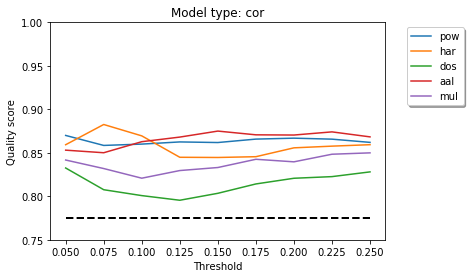

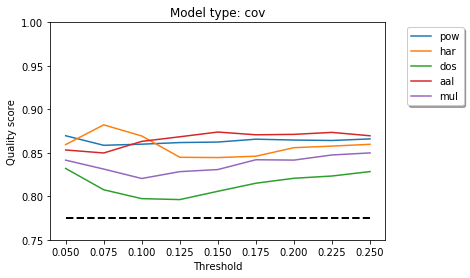

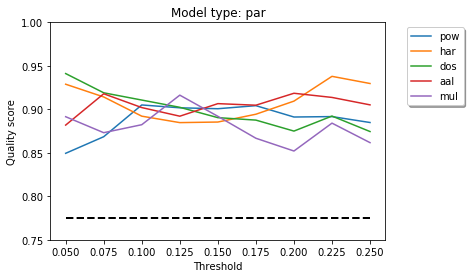

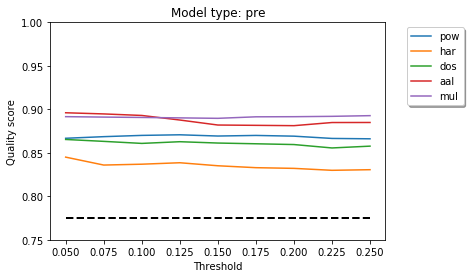

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for mod in meta['mod']:
    #--- 
    plt.plot(np.linspace(0.05,0.25,9),q[mod].T)
    if 'res' in globals():
        plt.plot(np.linspace(0.05,0.25,9), [res.fun for idx in range(9)], 'k--', linewidth=2)
    plt.xticks(np.linspace(0.05,0.25,9))
    plt.ylim((0.75,1))
    #--- cosmetic changes
    plt.title('Model type: {}'.format(mod))
    plt.xlabel('Threshold')
    plt.ylabel('Quality score')
    if 'res' in globals():
        meta_atl_leg = meta['atl'].copy(); 
        meta_atl_leg.append('optimal')
        plt.legend(meta['atl'], loc='upper center', bbox_to_anchor=(1.15, 1),
                  fancybox=True, shadow=True)
    else:
        plt.legend(meta['atl'], loc='upper center', bbox_to_anchor=(1.1, 1),
                  fancybox=True, shadow=True)
    plt.show()

### (B) Constrained optimization of metaparameter vector
Finding optimal metaparameter vector, i.e. beta weights vector $\vec{\beta}$ which yields highest identifiability $q = \frac{b_d}{w_d}$ for a given dataset. Contstrained optimization procedure called Sequential Least SQuares Programming (SLSQP) is used to find optimal beta values. Individual beta entries are strictly positive and less than one ($\forall i\;\; \beta_i\in\left[ 0,1\right]$). Beta values for individual dimensions of metaparameters show relative importance of certain metaparameter values (e.g. brain parcellations) while creating aggregated graph vectors with highest identifiability.

In [4]:
from identipy import beta_lin_comb
from identipy import quality_function
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import random
import time

path = 'data/graph/'

#--- load data
print('Loading the data...')
GVDAT, sub_list = load_data(path, meta)
print('Data succesfully loaded.\n')

#--- function to minimize
def quality_simple_fast(beta):
    beta = list(beta)
    gv_array = beta_lin_comb(beta, GVDAT, meta)
    return quality_function(sub_list, gv_array, similarity='euclid')

#--- initiate metaparameter vector
N_met = len(meta['atl']) + len(meta['mod']) + len(meta['thr']) 
b0 = np.asarray([random.uniform(0,1) for idx in range(N_met)])

#--- define constrains
bounds = Bounds([0 for idx in range (N_met)],[1 for idx in range (N_met)])
    
#--- minimize
print('Beginning optimization...')
res = minimize(quality_simple_fast, b0, method='SLSQP', options={'disp': True}, bounds=bounds)

Loading the data...
Data succesfully loaded.

Beginning optimization...
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7747968734943571
            Iterations: 62
            Function evaluations: 1240
            Gradient evaluations: 62


#### (B1) Plot bar charts showing optimal beta values for each metaparameter separately

Function minimum value: Q = 0.7748


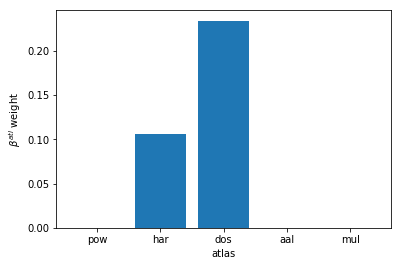

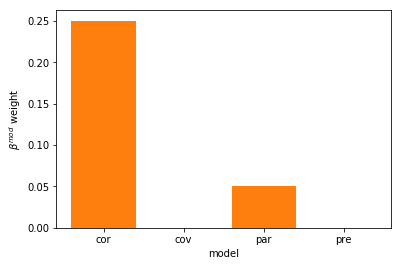

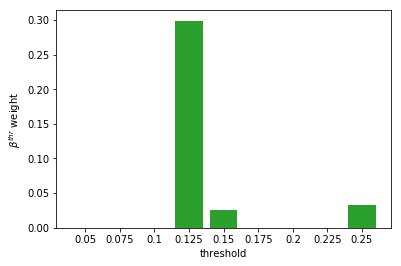

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#--- get optimal beta vector
b_opt = res.x / np.sum(res.x) # normalize
print(f'Function minimum value: Q = {round(res.fun, 4)}')

plt.bar(meta['atl'], b_opt[:5], color='C0')
plt.ylabel(r'$\beta^{atl}$ weight')
plt.xlabel('atlas')
plt.show()

plt.bar(meta['mod'], b_opt[5:9], color='C1')
plt.ylabel(r'$\beta^{mod}$ weight')
plt.xlabel('model')
plt.show()

plt.bar([str(thr) for thr in meta['thr']], b_opt[9:], color='C2')
plt.ylabel(r'$\beta^{thr}$ weight')
plt.xlabel('threshold')
plt.show()

#### (B2) Plot points MDS

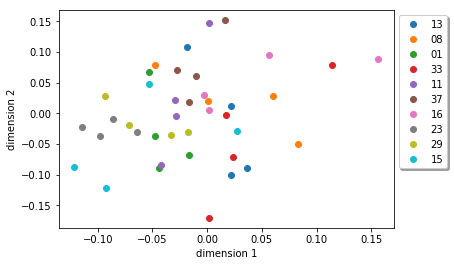

In [96]:
from sklearn.manifold import MDS

#--- gv's for optimal beta
gv_array = beta_lin_comb(list(b_opt), GVDAT, meta)

#--- multi-dimensional scaling of graph vectors
mds = MDS()
gv_mds = mds.fit_transform(gv_array)

#--- ten different subjects
N_plot = 10

#--- plot points in 2D-space
counter = 0
for sub in set(sub_list):
    if counter < N_plot:
        ses = [idx for idx, s in enumerate(sub_list) if sub in s]
        plt.plot(gv_mds[ses,0], gv_mds[ses,1], 'o', label=sub)
    counter += 1
plt.legend(bbox_to_anchor=(1, 1), fancybox=True, shadow=True)
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.show()